本文是基于pytorch环境的面向GNN基础算法的实现。
阅读本文前需要首先学习图的基本知识。

首先从torch_geometric加载数据集

In [8]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


# GCN 网络
以下实现对应于基础GCN的公式
H_l+1=sigma(D^-1 A H_l W_l)

In [ ]:
import torch
import torch.nn as nn
 
class GCNLayer(nn.Module):
 
    def __init__(self,c_in,c_out):
        """
        Inputs:
        :param c_in: 输入特征
        :param c_out: 输出特征
        """
        super().__init__()
        self.projection = nn.Linear(c_in,c_out); #线性层
        
    def forward(self,node_feats,adj_matrix):
        """
        输入
        :param node_feats: 节点特征表示，大小为[batch_size,num_nodes,c_in]
        :param adj_matrix: 邻接矩阵：[batch_size,num_nodes,num_nodes]
        :return:
        """
        # 各节点的邻居数, 度矩阵 D
        num_neighbors = adj_matrix.sum(dim=-1,keepdims=True) 
        # 将特征转化为消息 sigma(H_l W_l)
        node_feats = self.projection(node_feats)
        # 各邻居节点消息求和 A  H_l W_l
        node_feats = torch.bmm(adj_matrix,node_feats)
        # 用各节点的邻居数，求平均 D^-1 A H_l W_l
        node_feats = node_feats / num_neighbors
        
        return node_feats




现在测试上面的layer

In [2]:
node_feats = torch.arange(8,
dtype=torch.float32).view(1,4,2)
adj_matrix = torch.Tensor([[[1,1,0,0],
            [1,1,1,1],
            [0,1,1,1],
            [0,1,1,1]]])
print("节点特征：\n",node_feats)
print("添加自链接的邻接矩阵：\n",adj_matrix)

layer = GCNLayer(c_in=2, c_out=2)
# 初始化权重矩阵
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

# 将节点特征和添加自连接的邻接矩阵输入 GCN 层
with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("节点特征:\n", node_feats)
print("添加自连接的邻接矩阵:\n", adj_matrix)
print("节点输出特征:\n", out_feats)

节点特征：
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
添加自链接的邻接矩阵：
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
节点特征:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
添加自连接的邻接矩阵:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
节点输出特征:
 tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


利用 torch_geometric库的GCNConv，可以更容易地实现GCN 网络。以下例子包含了两层GCN layer。

input_channels 由数据集决定，等于每个节点的原始特征向量长度；
output_channels 由任务决定，等于分类任务的类别数；
hidden_channels 需要手动调节的超参数。常见值：16, 32, 64, 128

In [9]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(input_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, output_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(input_channels=dataset.num_features, hidden_channels=16, output_channels=dataset.num_classes)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


模型使用时输入节点信息 data.x 和边信息 data.edge_index，模型返回节点在各个类别的预测概率

In [ ]:
model.eval()  # 推理模式
with torch.no_grad():
    logits = model(data.x, data.edge_index) 
    pred = logits.argmax(dim=1)                 # 取概率最高的类别index

print("输出前5个特征:", logits[:5])  
print("输出前5个特征归类:", pred[:5])  

输出前5个特征: tensor([[-0.0049, -0.0059,  0.0002, -0.0036, -0.0001,  0.0093,  0.0080],
        [ 0.0067,  0.0053, -0.0011, -0.0028, -0.0023,  0.0003, -0.0026],
        [ 0.0029,  0.0030, -0.0002, -0.0019, -0.0020,  0.0045, -0.0024],
        [ 0.0013,  0.0024, -0.0063,  0.0047,  0.0025,  0.0042, -0.0065],
        [ 0.0052,  0.0032,  0.0013,  0.0025,  0.0009,  0.0023, -0.0023]])
输出前5个特征归类: tensor([5, 0, 5, 3, 0])


以下展示GCN网络的训练和测试过程函数

In [ ]:
# ---------- 3. 优化器 ----------
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# ---------- 4. 训练循环 ----------
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)          # 全图前向传播
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # 仅计算训练节点损失
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)                 # 取概率最高的类别
        # 通过比较预测值pred和真实标签data.y，分别计算训练集、验证集、测试集准确率
        train_acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean()
        val_acc = (pred[data.val_mask] == data.y[data.val_mask]).float().mean()
        test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean()
    return train_acc, val_acc, test_acc

# 开始训练
for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 20 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch 020, Loss: 1.7591, Train: 0.9357, Val: 0.6820, Test: 0.6900
Epoch 040, Loss: 1.3335, Train: 0.9500, Val: 0.7520, Test: 0.7610
Epoch 060, Loss: 0.9929, Train: 0.9643, Val: 0.7740, Test: 0.8040
Epoch 080, Loss: 0.6957, Train: 0.9714, Val: 0.7780, Test: 0.8070
Epoch 100, Loss: 0.5472, Train: 0.9857, Val: 0.7780, Test: 0.8160
Epoch 120, Loss: 0.4952, Train: 0.9857, Val: 0.7860, Test: 0.8130
Epoch 140, Loss: 0.4445, Train: 0.9857, Val: 0.7840, Test: 0.8060
Epoch 160, Loss: 0.3563, Train: 0.9857, Val: 0.7860, Test: 0.8120
Epoch 180, Loss: 0.3442, Train: 0.9929, Val: 0.7920, Test: 0.8050
Epoch 200, Loss: 0.3315, Train: 1.0000, Val: 0.7940, Test: 0.8120


# 数据集
已知节点特征和边可以构建图数据

In [ ]:
import torch
from torch_geometric.data import Data
# 基于节点的index表示边
#[0,1,1,2]表示出发的节点index
#[1,0,2,1]表示到达index
edge_index = torch.tensor([[0,1,1,2],
                           [1,0,2,1]],dtype=torch.long)
x = torch.tensor([[-1],[0],[1]],dtype=torch.float)#节点的特征矩阵，有3个节点，特征维度为1
 
data = Data(x=x,edge_index = edge_index) #初始化图
print(data)#查看图属性

下面给出一些torch_geometric数据集使用例子。首先拿ENZYMES数据集（包含600个图，每个图分为6个类别，图级别的分类）举例

In [ ]:
from torch_geometric.datasets import TUDataset
 
# 导入数据集
dataset = TUDataset(
    # 指定数据集的存储位置
    # 如果指定位置没有相应的数据集
    # PyG会自动下载
    root='data/ENZYMES',
    # 要使用的数据集
    name='ENZYMES',
)
# 数据集的长度
print(len(dataset))
# 数据集的类别数
print(dataset.num_classes)
# 数据集中节点属性向量的维度
print(dataset.num_node_features)
# 600个图，我们可以根据索引选择要使用哪个图
data = dataset[100]
print(data)
# 随机打乱数据集
dataset = dataset.shuffle()

把数据集分批次, 使用batch_size参数

In [ ]:
from torch_geometric.data import DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=True) # 批次大小为 32，并且数据的顺序随机打乱

for batch in loader:
    print("一批数据：",batch)
    print("一批数据量：",batch.num_graphs)

以 ShapeNet 中的 Airplane 数据集（3D 点云数据：指在一个三维坐标系统中的一组向量的集合）为例进行说明

In [ ]:
from torch_geometric.datasets import ShapeNet
dataset = ShapeNet(root='data/Airplane', categories=['Airplane'])
print(dataset[0])

用KNN 从点云生成最近邻图

In [ ]:
import torch_geometric.transforms as T
dataset = ShapeNet(root='data/Airplane', categories=['Airplane'],
                    pre_transform=T.KNNGraph(k=6)) # 进行 KNN 聚类操作

# 图数据的可视化
定义可视化函数

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
 
def visualize_networkx(graph, color):
    plt.figure(figsize=(8,8)) # 设定图画区域大小
    nx.draw_networkx(graph, with_labels=False,node_color=color) # 画图
    plt.show()

对图数据进行格式转化，转化为 networkx

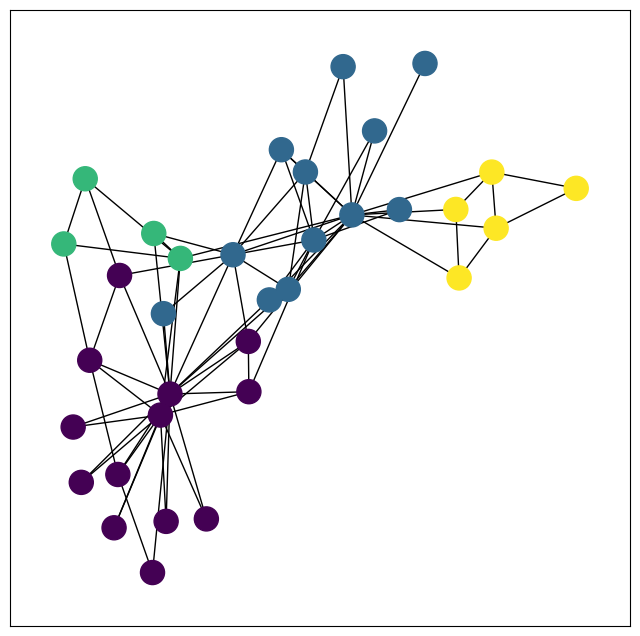

In [4]:
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
 
dataset = KarateClub()[0] # 取图数据集
G = to_networkx(dataset,to_undirected=True) # 转化为 networkx
visualize_networkx(G, color=dataset.y) # 画图

使用 sklearn.manifold.TSNE 和 matplotlib.pyplot 可视化未经训练的 GCN 网络的节点嵌入。它将绘制一个嵌入 2D 散点图的 7 维节点。

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

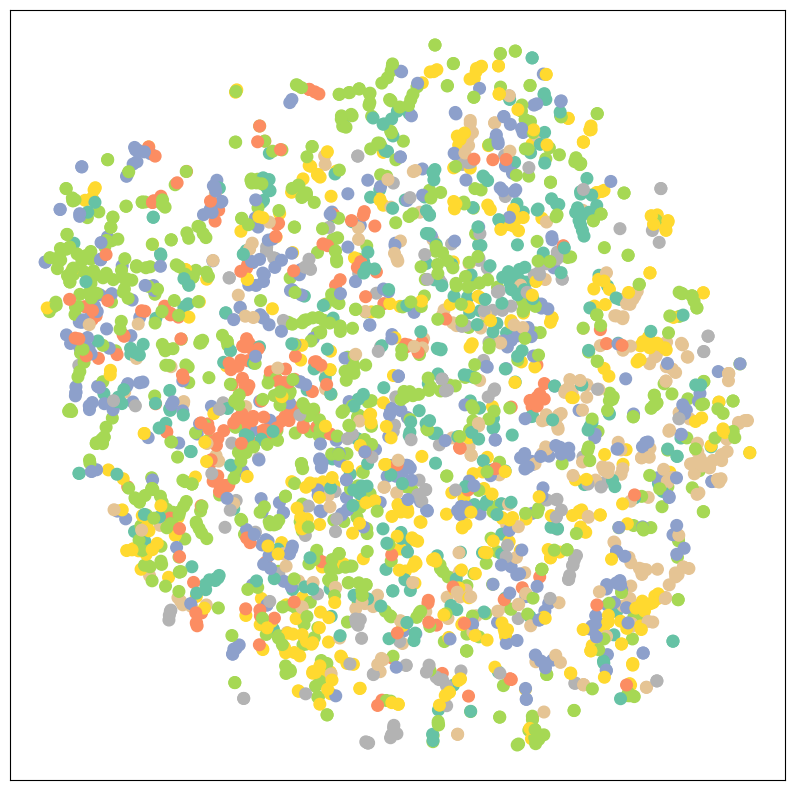

In [11]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)